# Costas Loop

This PLL is based on [this SDR PLL](http://liquidsdr.org/blog/pll-howto/) coded in C. Once this is working we will expand it to a more complex Costas Loop.

## Initialization of variables

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import string
#Store the shift registers as a deque, so that deque.rotate{} can be used.
from collections import deque  

# Initializations

phi_hat = 0.3      # phi_hat is the output phase - I channel
phi_hat_Q = phi_hat + np.pi/2    # phi_hat_Q is the output phase - Q channel
freq_offset = 0.3
delta_phi = 0.0    # delta_phi is the phase difference between the incomming signal and the VCO
wn = 0.01          # wn is omega_n, pll bandwidth
zeta = 0.707       # Damping factor of the loop
K = 1000           # K = loop gain, which I assume can be chosen, but this is a sample value
N = 300            # Number of samples

# Set tap for a particular satellite
tap = (1, 5)

# These are just initializing some vectors for plotting
ref = np.linspace(0, N, N, dtype=int)



# GoldCode class

In [3]:
class GoldCode:
      
    
    #Feedback taps as defined in GPS spec
    g1tap = [2,9]
    g2tap = [1,2,5,7,8,9]

    
    def __init__(self, taps):
        
        self.reset()
        self.tap = taps
        
        # Current index of the last returned code
        self.index = 0
        
    # Shift SRs
    def _shift(self):
        #Shift g1
        self.g1[9] = sum([self.g1[i] for i in self.g1tap]) % 2 
        self.g1.rotate()

        #Shift g2
        self.g2[9] = sum([self.g2[i] for i in self.g2tap]) % 2 
        self.g2.rotate()
        
        self.index = (self.index % 1023) + 1
        
    def reset(self):
        # Inititialize SRs as all 1's
        self.g1 = deque(1 for i in range(10))
        self.g2 = deque(1 for i in range(10))
        self.index = 0

    def getCode(self, num):
        #Returns a list of bits that form the Gold Code PRN of the designated satellite
        g = []

        for i in range(num):
            val = (self.g1[9] + self.g2[tap[0]] + self.g2[tap[1]]) % 2
            if val == 0:
                val = -1
        
            g.append(val)
            self._shift()

        return g

## Generate a sine wave to test with

This block generates a simple sine wave which is set by the phi and freq_offset parameters. 

In [4]:
phi = 0.0              # Original signal phase
def tstSignalGen(ref, phi, freq_offset):
    signal = []       # Save the signal_in for plotting
    
    # Retrieving Gold Code for first multiplication in block diagram on pg 94 of Borre
    PRN = GoldCode(tap)
    g = PRN.getCode(1023)
    
    for i in ref:

        # Complex input signal
        signal_in = np.cos(phi) + 1j*np.sin(phi)
        phi += freq_offset

        signal.append(signal_in) # Saved for plotting
    return signal

## Phase lock to input signal

This function takes a complex signal, and attempts to lock to it. It is currently only useful for example purposes.

The ax, tx, and bx variables are for the loop parameters. Using feedback theory I derived (ok, I stole) an equation in the form 

$\frac{b_0 z^{-1} + b_1 z^{-1} + b_2 z^{-1}}{a_0 z^{-1} + a_1 z^{-1} + a_2 z^{-1}}$

tx are just other ways of expressing the variables wn, zeta, and K. In standard form ${a_0 z^{-1} = 1}$, but here it was left in variable form and the variable assigned to be 1.

In [6]:
def phaseLock(signal, phi_hat, delta_phi):
    # Input should be a complex signal
    
    
    output = []            # Save the signal_out for plotting
    
    # Clear buffers
    v0 = 0.0           
    v1 = 0.0           
    v2 = 0.0      
    
    #Set parameters for feedback equation above
    a0 = 1.0
    a1 = -2.0
    a2 = 1.0

    t1 = K/(wn*wn)     # tau_1
    t2 = 2*zeta/wn     # tau_2

    b0 = (4*K/t1) * (1.0+t2/2.0)
    b1 = 8*K/t1
    b2 = (4*K/t1) * (1.0-t2/2.0)

    for sample in signal:

        # Complex oscillator signal - I channel
        vcoI = np.cos(phi_hat) + 1j*np.sin(phi_hat)
        # Complex oscillator signal - Q channel
        vcoQ = np.cos(phi_hat_Q) + 1j*np.sin(phi_hat_Q)

        delta_phi = np.angle(sample * np.conj(vcoI))
        output.append(vcoI)

        # vx varibles are a buffer to store output changes on transfer function variables ax and bx
        v2 =  v1
        v1 =  v0
        v0 =  delta_phi - v1 * a1 - v2 * a2
        phi_hat =  v0 * b0 + v1 * b1 + v2* b2
    return output



In [7]:
inputsignal = tstSignalGen(ref, phi, freq_offset)
lockedsig = phaseLock(inputsignal, phi_hat, delta_phi)

# Plot real & imaginary outputs

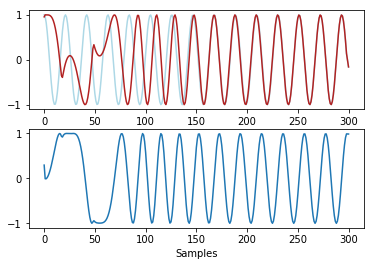

In [8]:

plt.subplot(2, 1, 1)
plt.plot(ref, np.real(inputsignal), color = 'lightblue')
plt.plot(ref, np.real(lockedsig), color = 'firebrick')



plt.subplot(2, 1, 2)
plt.plot(ref, np.imag(lockedsig))
plt.xlabel("Samples")

#plt.ylabel("Amplitude")
plt.show()

## 2 signal comparison

Tested 2 different signals for direct comparison

In [9]:
in1 = tstSignalGen(ref, 0.0, 0.3)
in2 = tstSignalGen(ref, 0.0, 0.09)

lock1 = phaseLock(in1, phi_hat, delta_phi)
lock2 = phaseLock(in2, phi_hat, delta_phi)

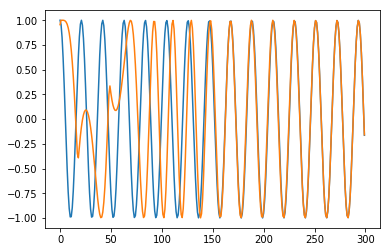

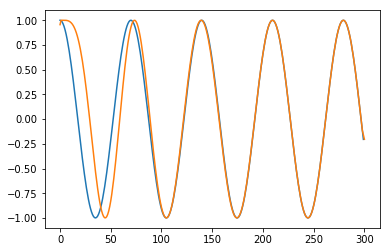

In [10]:
plt.plot(np.real(in1))
plt.plot(np.real(lock1))
plt.show()
plt.plot(np.real(in2))
plt.plot(ref, np.real(lock2))
plt.show()

